In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import StringIO
import json

In [82]:
def download_csv(url):
  req = requests.get(url).content
  return pd.read_csv(StringIO(req.decode("utf-8")))

In [83]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

In [84]:
covid19_sg_df = download_csv("https://raw.githubusercontent.com/hxchua/datadoubleconfirm/master/datasets/covid19_sg.csv")

In [85]:
start_date = covid19_sg_df["Date"][0]
start_date

'2020-01-23'

In [86]:
covid19_sg_df.tail()

,Date,Daily_Confirmed_,False_Positives_Found,Cumulative_Confirmed,Daily_Discharged,Passed_but_not_due_to_COVID,Cumulative_Discharged,Discharged_to_Isolation,Still_Hospitalised,Daily_Deaths,Cumulative_Deaths,Tested_positive_demise,Daily_Imported,Daily_Local_transmission,Local_cases_residing_in_dorms_MOH_report,Local_cases_not_residing_in_doms_MOH_report,Intensive_Care_Unit_(ICU),General_Wards_MOH_report,In_Isolation_MOH_report,Total_Completed_Isolation_MOH_report,Total_Hospital_Discharged_MOH_report
444,2021-04-11,20,0.0,60653,13,0,60357,230,28,0,30,0,19,1,1.0,0.0,1,57.0,230.0,57118.0,3217.0
445,2021-04-12,25,0.0,60678,22,0,60379,235,26,0,30,0,25,0,0.0,0.0,1,55.0,235.0,57135.0,3222.0
446,2021-04-13,14,0.0,60692,17,0,60396,227,31,0,30,0,14,0,0.0,0.0,1,60.0,227.0,57146.0,3228.0
447,2021-04-14,27,0.0,60719,18,0,60414,236,31,0,30,0,26,1,0.0,1.0,2,59.0,236.0,57161.0,3231.0
448,2021-04-15,16,0.0,60735,25,0,60439,231,27,0,30,0,16,0,0.0,0.0,2,55.0,231.0,57183.0,3234.0


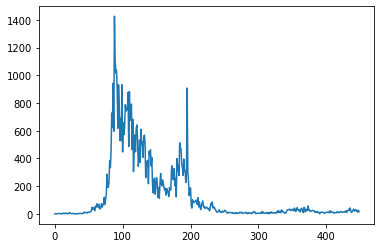

In [87]:
plt.plot(covid19_sg_df.index, covid19_sg_df["Daily_Confirmed_"])

In [88]:
import torch

In [89]:
# Reference: https://github.com/pytorch/examples/tree/master/time_sequence_prediction
class LSTM_Predictor(torch.nn.Module):
  def __init__(self, hidden_size):
    super(LSTM_Predictor, self).__init__()
    self.hidden_size = hidden_size
    self.lstm1 = torch.nn.LSTMCell(1, self.hidden_size)
    self.lstm2 = torch.nn.LSTMCell(self.hidden_size, self.hidden_size)
    self.nn = torch.nn.Sequential(
      torch.nn.Linear(self.hidden_size, int(self.hidden_size / 2)),
      torch.nn.Dropout(0.5),
      torch.nn.ReLU(),
      torch.nn.Linear(int(self.hidden_size / 2), 1)
    )
    
  def forward(self, input, future=0):
    outputs = []
    h_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.double).cuda()
    c_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.double).cuda()
    h_t2 = torch.zeros(input.size(0), self.hidden_size, dtype=torch.double).cuda()
    c_t2 = torch.zeros(input.size(0), self.hidden_size, dtype=torch.double).cuda()

    for input_t in input.split(1, dim=1):
        h_t, c_t = self.lstm1(input_t, (h_t, c_t))
        h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
        output = self.nn(h_t2)
        outputs += [output]
    for i in range(future):
        h_t, c_t = self.lstm1(output, (h_t, c_t))
        h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
        output = self.nn(h_t2)
        outputs += [output]
    outputs = torch.cat(outputs, dim=1)
    return outputs


In [90]:
# Reference: https://discuss.pytorch.org/t/rmse-loss-function/16540/3
class RMSELoss(torch.nn.Module):
  def __init__(self, eps=1e-6):
      super().__init__()
      self.mse = torch.nn.MSELoss()
      self.eps = eps
      
  def forward(self,yhat,y):
      loss = torch.sqrt(self.mse(yhat,y) + self.eps)
      return loss

In [91]:
# Reference: https://github.com/pytorch/examples/tree/master/time_sequence_prediction
def train(data, hidden_size=51, lr=0.05, epoch=800):
  training_input = data[:, :-1]
  training_target = data[:, 1:]
  model = LSTM_Predictor(hidden_size)
  model.train()
  model.double().cuda()
  criterion = RMSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr)

  losses = []

  for i in range(epoch):
    loss = float(
      criterion(
        model(training_input),
        training_target
      ).detach().cpu()
    )
    if i % 10 == 0:
      print('Epoch: {}, loss = {}'.format(i, loss))
    losses.append(loss)
    
    def closure():
      optimizer.zero_grad()
      out = model(training_input)
      loss = criterion(out, training_target)
      loss.backward()
      return loss
    optimizer.step(closure)
    
  return model, losses


In [ ]:
data = torch.tensor(covid19_sg_df["Daily_Confirmed_"].values).unsqueeze(dim=0).double().cuda()
divide_factor = 0.35
divider = int(data.size(1) * divide_factor)
truncated_data = data[:, :divider]
model, losses = train(
  truncated_data,
  hidden_size=150,
  lr=0.003,
  epoch=2500
)

In [93]:
# plt.plot(losses)

In [94]:
# torch.save(half_model, "model_{}_divider.pt".format(divide_factor))

In [100]:
def plot_predicted(model, data, future=0):
  model.train()
  bootstrap_size = 100
  # plt.figure(figsize=(9,6))
  results = np.empty((bootstrap_size, data.size(1) + future + 1))
  for i in range(bootstrap_size):
    result = model(data, future=future)[0].cpu().detach().numpy()
    result = np.insert(result, 0, data.cpu()[0, 0])
    results[i] = result
  stdev = results.std(axis=0)
  mean = results.mean(axis=0)
  max_value = results.max()
  plt.plot(covid19_sg_df.index, mean, label="Predicted", color="cyan", alpha=0.8)
  plt.fill_between(covid19_sg_df.index, mean-2*stdev, mean+2*stdev, alpha=0.4, color="cyan")
  plt.plot(covid19_sg_df.index, covid19_sg_df["Daily_Confirmed_"], label="Ground Truth", color="orange")
  plt.axvline(divider, 0, max_value, label="train/test divider", color="red")
  plt.legend()

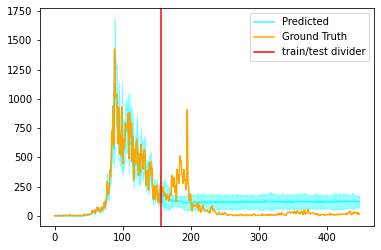

In [101]:
plot_predicted(model, truncated_data, future=data.size(1)-divider-1)

In [97]:
def test_loss(model, data, training_data, future):
  model.eval()
  prediction = model(training_data, future=future)[:, training_data.size(1)-1:training_data.size(1)-1+future]
  ground_truth = data[:, training_data.size(1):training_data.size(1)+future]
  loss_module = RMSELoss()
  return float(loss_module(ground_truth, prediction).cpu())

In [98]:
# test_loss(model, data, truncated_data, future=1)